In [1]:
'''
Load the necessary libraries
'''
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px

import seaborn as sns
import os
import glob

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
from sklearn.metrics import pairwise_distances_argmin_min
import hdbscan
from scipy.cluster.hierarchy import fcluster

import warnings
warnings.filterwarnings("ignore")

1


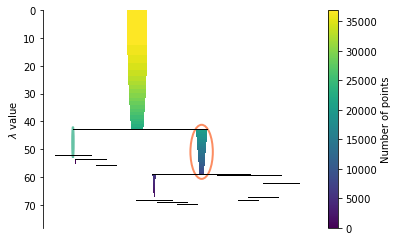

{0, 1, -1}
2


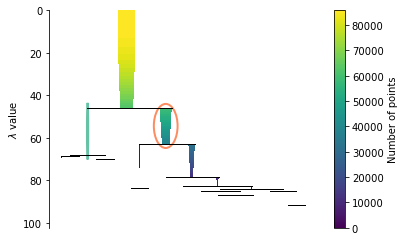

{0, 1, -1}
3


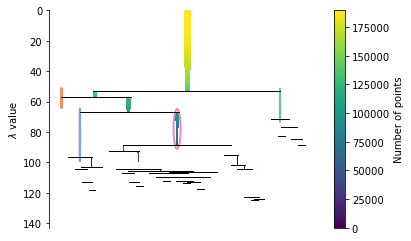

{0, 1, 2, 3, -1}
4


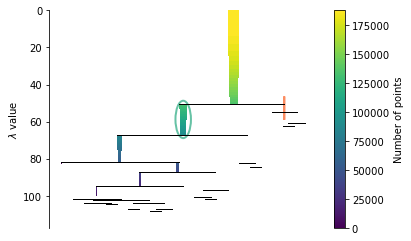

{0, 1, 2, 3, -1}


In [3]:
'''
Add morphology after the covd cluster analysis
For each covd cluster id, cluster based on morphology
'''
# Read the full dataframe with cluster IDs
df = pd.read_csv('/home/garner1/pipelines/WSI-analysis/SG/pipeline/data_intensity/csv/id_52.fov_centroids_embedding_morphology.covd.pkl.size900356.intensity.csv.gz')
df = df.sample(n=500000)

from sklearn import preprocessing
# rescale the features to 0-1 range
for feature in ["area","perimeter","solidity","eccentricity"]:
    f = df[feature].as_matrix().reshape(-1,1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    f_scaled = min_max_scaler.fit_transform(f)
    df[feature] = f_scaled

df["cluster_morphology"] = -1 # initialize the morphological cluster id
for c_id in set(df.cluster_intensity): # for each cluster id
    print(c_id)
    # cluster with HDBSCAN
    min_cluster_size = 50 # parameter to be adjausted
    min_samples = 100       # parameter to be adjausted
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples,
                                min_cluster_size=min_cluster_size,
                                gen_min_span_tree=True)
    clusterer.fit( df[df["cluster_intensity"] == c_id][["area","perimeter","solidity","eccentricity"]] ) 
    clusterer.condensed_tree_.plot(select_clusters=True,
                                   selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    #plt.savefig(filename+'.tree.intensity.png')
    plt.show()
    #update datarrame
    df.loc[df.cluster_intensity == c_id, "cluster_morphology"] = clusterer.labels_
    print(set(df["cluster_morphology"] ))

# merge the two cluster ids into a single one
df["cluster"] = df["cluster_intensity"].astype(str) +"_"+df["cluster_morphology"].apply(str)

In [6]:
# Define a pairing function to label uniquely pairs of morpho and intensity clusters
def cantor(n,m):
    return 0.5*(n+m)*(n+m+1)+m

df_labeled = df[df["cluster_morphology"] != -1] # filter out unlabeled morphological clusters
df_labeled["pairing"] = cantor(df_labeled["cluster_intensity"],df_labeled["cluster_morphology"]) 

#define a dictionary to rewrite the paired labels in a continuous way
dic = {}
labels = set(df_labeled["pairing"])
for counter, value in enumerate(list(labels)):
    dic[value] = counter
    
df_labeled['pairing'] = df_labeled['pairing'].map(dic) 

df_labeled.to_pickle('test.pkl')

In [35]:
df.head()

,fov_row,fov_col,cx,cy,xi,yi,zi,area,perimeter,solidity,eccentricity,mean_intensity,curvature,cluster_intensity,cluster_morphology,cluster,pairing,counter
308175,40,34,17598.367089,20501.930380,-6.346089,-4.795735,-1.276656,0.060619,0.149510,0.904762,0.850732,12.430380,0.263096,2,0,2_0,4,4
260670,9,22,11332.793814,4852.463918,-0.145115,6.520666,-3.817358,0.035464,0.102632,0.921569,0.769623,22.268041,0.251305,3,0,3_0,7,7
717656,27,31,16363.818182,14061.488636,2.634472,0.826367,6.961854,0.031753,0.103465,0.882105,0.791959,28.977273,0.283988,4,1,4_1,12,12
104896,4,8,4503.139073,2437.105960,-3.968443,-0.641997,-6.960572,0.057732,0.131758,0.948718,0.429048,17.629139,0.232535,3,0,3_0,7,7
29875,40,30,15541.577586,20886.465517,6.081355,-5.792625,-2.531138,0.043299,0.130926,0.838760,0.867060,41.422414,0.168976,4,1,4_1,12,12


In [10]:
# project the cluster ids on the WSI
fig = px.scatter(df[df.cluster_morphology != '-1'],
                 x="cx", y="cy",color="cluster",
                 width=800, height=800,
                 color_discrete_sequence=px.colors.qualitative.Dark24)
fig.update_traces(marker=dict(size=2,opacity=0.9))
fig.update_layout(template='simple_white')
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.write_html('test.spatial_projection.intensity.html', auto_open=True)
        